In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pasos
- Cargar datos 
- Normalizar datos 
- Agregar una columna de unos
- Calcular la prediccion (theta tanspuesta por X vector) 
- Calcular el costo (error)
- Dos formas para calcular los parámetros (thetas)
    - Ecuacion normal (X entrenaminto * producto matricil-< inversa - Xt entrenamiento Y(años que vivere))
    - Gradiente Descendiente 

In [17]:
def Leer_Datos(filename,atrributes):
    data = pd.read_csv(filename, usecols=atrributes) 
    return data

In [18]:
def Normalizar_Datos(data):
    mean_ = data.mean(axis=0)
    std_ = data.std(axis=0) #estandar
    return (data - mean_)/std_

In [19]:
def Sigmoidal(theta,X):
    return 1 / (1 + np.exp( -np.dot(X,theta) ) )        
    #return 1 / (1 + np.exp( -np.dot(X,theta.T) ) )    

In [20]:
def train_test(data): 
    porcentage = 0.70
    np.random.shuffle(data)
    rows = int(porcentage * len(data))
    #int((70*len(data))/100)
    train = data[:rows, :]
    test = data[rows:, :]
    #X_train = data[:rows, :col]
    #y_train = data[:rows, col]
    #X_test = data[rows:, :col]
    #y_test = data[rows:, col]
    return train, test

In [21]:
def divide_X_y(data):
    col = data.shape[1]-1
    X = data[:, :col]
    y = data[:, col:]
    return X, y

In [22]:
# Add a column of ones (bias)
def add_ones(X_train, y_train, X_test, y_test):
    n_exa_train = len(y_train)
    n_exa_test = len(y_test)

    X_train = np.concatenate((np.ones([n_exa_train, 1]), X_train), axis=1)
    X_test = np.concatenate((np.ones([n_exa_test, 1]), X_test), axis=1)
    
    return X_train, X_test

In [70]:
def calcular_funcion_costo(X,y, theta):
    m = y.shape[0]
    predictions = Sigmoidal(theta,X) 
    #predictions = np.rint(predictions)
    #print(predictions)
    error = (y * np.log(predictions)) + ((1-y) * np.log(1-predictions))
    #error = (y.dot(np.log(predictions))) + ((1-y) * np.log(1-predictions))
    return (-1/m) * (np.sum(error))

In [84]:
def gradient_descent(X, y, theta, nro_iter, learning_rate): 
    m = X.shape[0] #nbr of training data
    #cost_history = np.empty(nro_iter, dtype=float) 
    cost_history = np.zeros(nro_iter) 

    for i in range(nro_iter):
        pred = Sigmoidal(theta, X)
        pred = pred - y   
        cost_history[i] = calcular_funcion_costo( X, y, theta) 
        #print((learning_rate * ((np.matmul(X.T,pred))/m)).shape)
        #print(theta.shape)
        theta = theta - (learning_rate * ((np.matmul(X.T,pred))/m))
        #theta = theta - (learning_rate * ((np.matmul(pred,X))/m))
    return theta, cost_history

In [25]:
def accuracy(X, y, theta):
    predict = Sigmoidal(theta, X)
    #print("predict: ",predict)
    probab_threshold = 0.5  
    predicted_classes = (predict >= probab_threshold)
    result = np.logical_xor(np.logical_not(predicted_classes), y)
    return np.sum(result) / y.shape[0]

In [26]:
def create_k_folds(data, k):
    np.random.shuffle(data)
    col_class = data[:,-1]
    #col_class = np.array([0,0,1,0,1,0,1,0,0,0])
    num_rows = col_class.shape[0]
    unique, counts = np.unique(col_class, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(distribution)
    percent_of_first_class = round((distribution[0.0] * 100) /  num_rows)
   
    percent_of_second_class = round((distribution[1.0] * 100) / num_rows)
   
    num_per_fold = round(num_rows/k)
    
    num_first_class_per_fold = round((num_per_fold * percent_of_first_class)/100)
    num_second_class_per_fold = round((num_per_fold * percent_of_second_class)/100)

    list_indices=[]
    num_0s=[]
    num_1s=[]
    
    for i in range(k):
        list_indices.append([])
        num_0s.append(0)
        num_1s.append(0)

    for i in range(num_rows):
    
        if col_class[i] == 0.0:
            for j in range(k):
                if(num_0s[j]<num_first_class_per_fold):
                    num_0s[j]+=1
                    #print(list_indices[j],list_indices[j].count(0))
                    list_indices[j].append(i)
                    break

        else:
            for j in range(k):
                if(num_1s[j]<num_second_class_per_fold):
                    num_1s[j]+=1
                    list_indices[j].append(i)
                    break

    if num_rows%k!=0:
        list_indices[k-1].append(col_class.shape[0]-1)
    
    return list_indices
    
    #print(list_indices[0])
    #print(list_indices[1])
    #print(list_indices[2])

In [27]:
def PrepareXandY(training,test):
    train_X = training[:,:-1]
    train_X = np.concatenate((np.ones([train_X.shape[0], 1]), train_X), axis=1)

    test_X = test[:,:-1]
    test_X = np.concatenate((np.ones([test_X.shape[0], 1]), test_X), axis=1)

    train_y = training[:,-1]
    test_y = test[:,-1]

    return train_X, train_y, test_X, test_y

#### EXPERIMENTO I

In [78]:
def GD_find_parameters():
    files = [("Data_classification/weatherAUS.csv",["MinTemp","MaxTemp","RainToday","RainTomorrow"])]
    for f in files:
        f_name = f[0]
        atrributes = f[1]
        k = 3
        data = Leer_Datos(f_name,atrributes)
        data = data.replace(to_replace='Yes',value=1,regex=True)
        data = data.replace(to_replace='No',value=0,regex=True)

        data = data.values[~np.isnan(data).any(axis=1)]
        data[:,0:2] = Normalizar_Datos(data[:,0:2])
      
        indices = create_k_folds(data, k)
        #print(indices)

        fold1 = data[indices[0]]
        fold2 = data[indices[1]]
        fold3 = data[indices[2]]


        learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
        
        training1 = np.concatenate((fold1,fold2))
        training2 = np.concatenate((fold3,fold2))
        training3 = np.concatenate((fold3,fold1))
        
        train_X1, train_y1, test_X1, test_y1 = PrepareXandY(training1,fold3)
        train_X2, train_y2, test_X2, test_y2 = PrepareXandY(training2,fold1)
        train_X3, train_y3, test_X3, test_y3 = PrepareXandY(training3,fold2)

        for tasa in learning_rate:
            for ite in range(500,3501,500):
                print("tasa: ", tasa, " iteracion: ", ite)
                theta_test1 = np.zeros(train_X1.shape[1])
                theta_test2 = np.zeros(train_X2.shape[1])
                theta_test3 = np.zeros(train_X3.shape[1])
                
                theta_test1, cost_history1 = gradient_descent(train_X1, train_y1, theta_test1, ite, tasa)
                theta_test2, cost_history2 = gradient_descent(train_X2, train_y2, theta_test2, ite, tasa) 
                theta_test3, cost_history3 = gradient_descent(train_X3, train_y3, theta_test3, ite, tasa) 
                
                
                accuracy1 = accuracy(test_X1 , test_y1, theta_test1)
                accuracy2 = accuracy(test_X2 , test_y2, theta_test2)
                accuracy3 = accuracy(test_X3 , test_y3, theta_test3)

                print((accuracy1+accuracy2+accuracy3)/3)


        

        
GD_find_parameters()

tasa:  0.01  iteracion:  500
[[ 1.          0.15876268 -0.89018049  1.        ]
 [ 1.          0.40860619  0.34664365  0.        ]
 [ 1.          1.12690627  0.20609545  0.        ]
 ...
 [ 1.         -1.05922442 -0.79179675  0.        ]
 [ 1.         -0.24723302  0.72612378  0.        ]
 [ 1.         -0.09108083  0.75423342  0.        ]]
[0. 1. 1. ... 0. 0. 0.]
[[ 1.          0.03384093 -0.70746783  1.        ]
 [ 1.         -0.1535417  -0.48259071  1.        ]
 [ 1.          0.08068658 -0.9042353   1.        ]
 ...
 [ 1.         -1.05922442 -0.79179675  0.        ]
 [ 1.         -0.24723302  0.72612378  0.        ]
 [ 1.         -0.09108083  0.75423342  0.        ]]
[1. 1. 1. ... 0. 0. 0.]
[[ 1.          0.03384093 -0.70746783  1.        ]
 [ 1.         -0.1535417  -0.48259071  1.        ]
 [ 1.          0.08068658 -0.9042353   1.        ]
 ...
 [ 1.         -0.01300473  1.09154909  1.        ]
 [ 1.          1.67343894  0.71206896  1.        ]
 [ 1.         -0.2316178  -0.94639976  

KeyboardInterrupt: 

In [85]:
def GD_find_parameters1():
    files = [ ("Data_classification/titanic_test.csv",["Sex","Age","Fare","Embarked"]), 
              ("Data_classification/gender_submission.csv",["Survived"]),
              ("Data_classification/titanic_train.csv",["Sex","Age","Fare","Embarked","Survived"]) ]
    
    f_name = files[0][0]
    atrributes = files[0][1]
    k = 3
    data = Leer_Datos(f_name,atrributes)
    data = data.replace(to_replace='female',value=1,regex=True)
    data = data.replace(to_replace='male',value=0,regex=True)
    data = data.replace(to_replace='C',value=0,regex=True)
    data = data.replace(to_replace='S',value=1,regex=True)
    data = data.replace(to_replace='Q',value=2,regex=True)

    f_name = files[1][0]
    atrributes = files[1][1]
    data2 = Leer_Datos(f_name,atrributes)

    data = np.concatenate((data, data2), axis=1)

    f_name = files[2][0]
    atrributes = files[2][1]
    data3 = Leer_Datos(f_name,atrributes)

    data3 = data3[["Sex","Age","Fare","Embarked","Survived"]]

    data3 = data3.replace(to_replace='female',value=1,regex=True)
    data3 = data3.replace(to_replace='male',value=0,regex=True)
    data3 = data3.replace(to_replace='C',value=0,regex=True)
    data3 = data3.replace(to_replace='S',value=1,regex=True)
    data3 = data3.replace(to_replace='Q',value=2,regex=True)

    data = np.concatenate((data, data3), axis=0)

    
    data = data[~np.isnan(data).any(axis=1)]
    data[:,1:3] = Normalizar_Datos(data[:,1:3])
      
    indices = create_k_folds(data, k)
        #print(indices)

    fold1 = data[indices[0]]
    fold2 = data[indices[1]]
    fold3 = data[indices[2]]


    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
        
    training1 = np.concatenate((fold1,fold2))
    training2 = np.concatenate((fold3,fold2))
    training3 = np.concatenate((fold3,fold1))
        
    train_X1, train_y1, test_X1, test_y1 = PrepareXandY(training1,fold3)
    train_X2, train_y2, test_X2, test_y2 = PrepareXandY(training2,fold1)
    train_X3, train_y3, test_X3, test_y3 = PrepareXandY(training3,fold2)

    for tasa in learning_rate:
        for ite in range(500,3501,500):
            print("tasa: ", tasa, " iteracion: ", ite)
            theta_test1 = np.zeros(train_X1.shape[1])
            theta_test2 = np.zeros(train_X2.shape[1])
            theta_test3 = np.zeros(train_X3.shape[1])
                
            theta_test1, cost_history1 = gradient_descent(train_X1, train_y1, theta_test1, ite, tasa)
            theta_test2, cost_history2 = gradient_descent(train_X2, train_y2, theta_test2, ite, tasa) 
            theta_test3, cost_history3 = gradient_descent(train_X3, train_y3, theta_test3, ite, tasa) 
                
                
            accuracy1 = accuracy(test_X1 , test_y1, theta_test1)
            accuracy2 = accuracy(test_X2 , test_y2, theta_test2)
            accuracy3 = accuracy(test_X3 , test_y3, theta_test3)

            print((accuracy1+accuracy2+accuracy3)/3)
 

        
GD_find_parameters1()

tasa:  0.01  iteracion:  500
0.7382655934280699
tasa:  0.01  iteracion:  1000
0.8139802577097618
tasa:  0.01  iteracion:  1500
0.8264544480881558
tasa:  0.01  iteracion:  2000
0.8312492408934822
tasa:  0.01  iteracion:  2500
0.8369991277176013
tasa:  0.01  iteracion:  3000
0.8379569821237315
tasa:  0.01  iteracion:  3500
0.8417911601355903
tasa:  0.05  iteracion:  500
0.8369991277176013
tasa:  0.05  iteracion:  1000
0.8427490145417206
tasa:  0.05  iteracion:  1500
0.8446702441286561
tasa:  0.05  iteracion:  2000
0.8446702441286561
tasa:  0.05  iteracion:  2500
0.8446702441286561
tasa:  0.05  iteracion:  3000
0.8446702441286561
tasa:  0.05  iteracion:  3500
0.8446702441286561
tasa:  0.1  iteracion:  500
0.8427490145417206
tasa:  0.1  iteracion:  1000
0.8446702441286561
tasa:  0.1  iteracion:  1500
0.8446702441286561
tasa:  0.1  iteracion:  2000
0.8446702441286561
tasa:  0.1  iteracion:  2500
0.8446702441286561
tasa:  0.1  iteracion:  3000
0.8456280985347865
tasa:  0.1  iteracion:  3500


#### EXPERIMENTO II

[[ 1.          0.          0.32639308 -0.51633622  2.        ]
 [ 1.          1.          1.19690507 -0.53121592  1.        ]
 [ 1.          0.          2.24151945 -0.48298967  2.        ]
 ...
 [ 1.          1.         -0.75304177 -0.11848896  1.        ]
 [ 1.          0.         -0.26555506 -0.11848896  0.        ]
 [ 1.          0.          0.15229069 -0.51775743  2.        ]]
[0. 1. 0. ... 1. 1. 0.]
Weights of gradient_descent - training data:  [-0.75336614  2.20222687 -0.16883034  0.43051355 -0.55687642] 

[0.69314718 0.68784436 0.68278639 0.67795562 0.67333577 0.66891186
 0.66467007 0.6605977  0.65668305 0.65291537 0.6492848  0.64578224
 0.64239936 0.63912849 0.63596257 0.63289512 0.62992018 0.62703225
 0.62422629 0.62149762 0.61884196 0.61625535 0.61373412 0.61127488
 0.6088745  0.60653009 0.60423896 0.6019986  0.5998067  0.59766111
 0.59555982 0.59350095 0.59148276 0.58950362 0.58756199 0.58565646
 0.58378568 0.58194839 0.5801434  0.57836962 0.57662597 0.57491149
 0.57322522 0

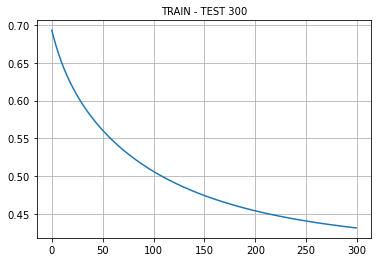

In [83]:
def GD_ploteo():
    files = [ ("Data_classification/titanic_test.csv",["Sex","Age","Fare","Embarked"]), 
              ("Data_classification/gender_submission.csv",["Survived"]),
              ("Data_classification/titanic_train.csv",["Sex","Age","Fare","Embarked","Survived"]) ]
    
    f_name = files[0][0]
    atrributes = files[0][1]
  
    data = Leer_Datos(f_name,atrributes)
    data = data.replace(to_replace='female',value=1,regex=True)
    data = data.replace(to_replace='male',value=0,regex=True)
    data = data.replace(to_replace='C',value=0,regex=True)
    data = data.replace(to_replace='S',value=1,regex=True)
    data = data.replace(to_replace='Q',value=2,regex=True)

    f_name = files[1][0]
    atrributes = files[1][1]
    data2 = Leer_Datos(f_name,atrributes)

    data = np.concatenate((data, data2), axis=1)

    f_name = files[2][0]
    atrributes = files[2][1]
    data3 = Leer_Datos(f_name,atrributes)

    data3 = data3[["Sex","Age","Fare","Embarked","Survived"]]

    data3 = data3.replace(to_replace='female',value=1,regex=True)
    data3 = data3.replace(to_replace='male',value=0,regex=True)
    data3 = data3.replace(to_replace='C',value=0,regex=True)
    data3 = data3.replace(to_replace='S',value=1,regex=True)
    data3 = data3.replace(to_replace='Q',value=2,regex=True)

    data = np.concatenate((data, data3), axis=0)

    
    data = data[~np.isnan(data).any(axis=1)]
    data[:,1:3] = Normalizar_Datos(data[:,1:3])

        
    nb_iteration = 300
    learn_rate = 0.1
    

    X_train, y_train, test_X1, test_y1 = PrepareXandY(data,data)

    theta = np.zeros(X_train.shape[1])

    theta_gd, cost_history = gradient_descent(X_train, y_train, theta, nb_iteration, learn_rate)

    error_train = calcular_funcion_costo(X_train, y_train, theta_gd)
 
       
    fig, ax = plt.subplots()
    plt.plot(range(len(cost_history)), cost_history)

    plt.title('TRAIN - TEST '+str(nb_iteration), {'fontsize':10})
    print("Weights of gradient_descent - training data: ", theta_gd, "\n")

    print(cost_history)
   
    ax.grid(True)
    plt.show()
GD_ploteo()

#### EXPERIMENTO III

One vs One

In [ ]:
def multiclass1():
    #data = Leer_Datos('Iris.csv')
    filename = 'Iris.csv'
    data = pd.read_csv(filename)
    cant_x_class = data[data.columns[data.shape[1]-1]].value_counts()

    learn_rate = 0.1 # DEFAULT
    nb_iterations = 1000
    W_array = []    
    accuracy_array_test = []
    
    data = np.array(data)     
    X, y = divide_X_y(data)
    y_classes = np.unique(y)
    X_normalizada = Normalizar_Datos(X)
    data_normalizada = np.concatenate((X_normalizada, y), axis=1)
    train, test = train_test(data_normalizada) # verificar la division random de train and test
    categories_train = []
    for i in range(0, y_classes.shape[0]):
        category = train[train[:, train.shape[1]-1] == y_classes[i]]
        categories_train.append(category)   
    
    for i in range(0, y_classes.shape[0]):
        for j in range(i+1, y_classes.shape[0]):
            tmp_data = np.concatenate((categories_train[i], categories_train[j]), axis=0)
            #tmp_data = np.concatenate([np.expand_dims(i,axis=0) for i in [y_classes[i],y_classes[j]]])
            
            posiciones_a_cambiar = np.where(tmp_data == y_classes[i]) 
            tmp_data = np.c_[tmp_data[:, :tmp_data.shape[1]-1], np.zeros(tmp_data.shape[0])]
            tmp_data[posiciones_a_cambiar] = 1
            np.random.shuffle(tmp_data)
            
            set_train, set_test = train_test(tmp_data)
            X_train, y_train = divide_X_y(set_train)
            X_test, y_test = divide_X_y(set_test)
            y_train = np.reshape(y_train, y_train.shape[0])
            y_test = np.reshape(y_test, y_test.shape[0])
        
            X_train = np.c_[X_train, np.ones(X_train.shape[0])]     #bias
            X_test = np.c_[X_test, np.ones(X_test.shape[0])]        #bias
        
            theta = np.random.rand(X_train.shape[1])
            X_train = X_train.astype(float)
            y_train = y_train.astype(int)
            W, cost_history = gradient_descent(X_train, y_train, theta, nb_iterations, learn_rate)
            W_array.append(W)
            
            X_test = X_test.astype('float')
            y_test = y_test.astype(int)
            accuracy_test = accuracy(X_test, y_test, W)
            accuracy_array_test.append(accuracy_test)
            
    #print(W_array)
    print('Iris-setosa vs Iris-versicolor, Iris-setosa vs Iris-virginica, Iris-versicolor vs virginica')
    print(accuracy_array_test)
    
multiclass1()

In [238]:
def multiclass1_cross_validation():
    filename = 'Iris.csv'
    data = pd.read_csv(filename)

    learn_rate = 0.1 # DEFAULT
    nb_iterations = 1000
    W_array = [] 
    accuracy_array_test = []
    k = 3

    X, y = divide_X_y(data.values)
    y_classes = np.unique(y)
    X_normalizada = Normalizar_Datos(X)
    data_normalizada  = np.concatenate((X_normalizada , y), axis=1)
    train, test = train_test(data_normalizada) # verificar la division random de train and test
    categories_train = []
    for i in range(0, y_classes.shape[0]):
        category = train[train[:, train.shape[1]-1] == y_classes[i]]
        categories_train.append(category)  
    # k_set_X[0], k_set_y[0] return first element of e/array
    #k_set_X, k_set_y = create_k_folds(pd.DataFrame(data_normalizada), k)    
    k_set = create_k_folds(pd.DataFrame(data_normalizada), k)
    
    for c in range(y_classes.shape[0]):
        for c1 in range(c+1, y_classes.shape[0]):
            tmp_data = np.concatenate((categories_train[c], categories_train[c1]), axis=0)
            
            total_accuracy_test = 0
            for i_test in range(0, k): 
                X_test = np.zeros ( (0, np.size(k_set[0]['X'])) )
                y_test = np.zeros ( (0, np.size(k_set[0]['y'])) )
                X_train = np.zeros( (0, (np.size(k_set[0]['X'])) * (y_classes.shape[0]-1)) )
                y_train = np.zeros( (0, (np.size(k_set[0]['y'])) * (y_classes.shape[0]-1)) )
                
                for j in range(0, k): 
                    if (i_test == j):
                        X_test = k_set[i_test]['X']
                        y_test = k_set[i_test]['y'] == y_classes[c]
                        #y_train[ np.where( k_set[i_test]['y'] == y_classes[c]) ] = 1
                    else:
                        X_train = k_set[j]['X']
                        y_train = k_set[j]['y'] == y_classes[c]  
                
                y_train = np.reshape(y_train, y_train.shape[0])
                y_test = np.reshape(y_test, y_test.shape[0])

                X_train = np.c_[X_train, np.ones(X_train.shape[0])]     #bias
                X_test = np.c_[X_test, np.ones(X_test.shape[0])]        #bias

                theta = np.random.rand(np.size(X_train[0]))
                X_train = X_train.astype(float)
                y_train = y_train.astype(int)
                W, cost_history = gradient_descent(X_train, y_train, theta, nb_iterations, learn_rate)
                W_array.append(W)

                X_test = X_test.astype('float')
                y_test = y_test.astype(int)
                accuracy_test = accuracy(X_test, y_test, W)
                total_accuracy_test += accuracy_test

            total_accuracy_test = total_accuracy_test / k
            accuracy_array_test.append(accuracy_test)

    print('Iris-setosa, Iris-versicolor, Iris-virginica')
    print(accuracy_array_test)
    
multiclass1_cross_validation()    

Iris-setosa, Iris-versicolor, Iris-virginica
[1.0, 1.0, 0.7]


One vs All

In [169]:
def multiclass2():
    filename = 'Iris.csv'
    data = pd.read_csv(filename)

    learn_rate = 0.1 # DEFAULT
    nb_iterations = 1000
    data = data.sample(frac=1)
    k = 3

    X, y = divide_X_y(data.values)
    X_normalizada = Normalizar_Datos(X)
    data_normalizada  = np.concatenate((X_normalizada , y), axis=1)
    train, test = train_test(data_normalizada) 

    W_array = [] 
    y_classes = np.unique(y)
    accuracy_array_test = []

    for c in range(y_classes.shape[0]):  
        tmp_data = np.c_[train[:, :train.shape[1]-1], np.zeros(train.shape[0])]
        tmp_data[np.where(train == y_classes[c])] = 1
        
        set_train, set_test = train_test(tmp_data)
        X_train, y_train = divide_X_y(set_train)
        X_test, y_test = divide_X_y(set_test)
        y_train = np.reshape(y_train, y_train.shape[0])
        y_test = np.reshape(y_test, y_test.shape[0])
        
        X_train = np.c_[X_train, np.ones(X_train.shape[0])]     #bias
        X_test = np.c_[X_test, np.ones(X_test.shape[0])]        #bias
        
        theta = np.random.rand(X_train.shape[1])
        X_train = X_train.astype(float)
        y_train = y_train.astype(int)
        W, cost_history = gradient_descent(X_train, y_train, theta, nb_iterations, learn_rate)
        W_array.append(W)
            
        X_test = X_test.astype('float')
        y_test = y_test.astype(int)
        accuracy_test = accuracy(X_test, y_test, W)
        accuracy_array_test.append(accuracy_test)
        
    print('Iris-setosa, Iris-versicolor, Iris-virginica')
    print(accuracy_array_test)
    
multiclass2()    

Iris-setosa, Iris-versicolor, Iris-virginica
[1.0, 0.78125, 0.96875]


In [227]:
def multiclass2_cross_validation():
    filename = 'Iris.csv'
    data = pd.read_csv(filename)

    learn_rate = 0.1 # DEFAULT
    nb_iterations = 1000
    data = data.sample(frac=1)
    k = 3

    X, y = divide_X_y(data.values)
    X_normalizada = Normalizar_Datos(X)
    data_normalizada  = np.concatenate((X_normalizada , y), axis=1)
        
    k_set = create_k_folds(pd.DataFrame(data_normalizada), k)
   
    W_array = [] 
    y_classes = np.unique(y)
    accuracy_array_test = []
    
    for c in range(y_classes.shape[0]):
        total_accuracy_test = 0
        for i_test in range(0, k): 
            X_test = np.zeros ( (0, np.size(k_set[0]['X'])) )
            y_test = np.zeros ( (0, np.size(k_set[0]['y'])) )
            X_train = np.zeros( (0, (np.size(k_set[0]['X'])) * (y_classes.shape[0]-1)) )
            y_train = np.zeros( (0, (np.size(k_set[0]['y'])) * (y_classes.shape[0]-1)) )
     
            for j in range(0, k): 
                if (i_test == j):
                    X_test = k_set[i_test]['X']
                    y_test = k_set[i_test]['y'] == y_classes[c]
                    #y_train[ np.where( k_set[i_test]['y'] == y_classes[c]) ] = 1
                else:
                    X_train = k_set[j]['X']
                    y_train = k_set[j]['y'] == y_classes[c]                   

            y_train = np.reshape(y_train, y_train.shape[0])
            y_test = np.reshape(y_test, y_test.shape[0])
            
            X_train = np.c_[X_train, np.ones(X_train.shape[0])]     #bias
            X_test = np.c_[X_test, np.ones(X_test.shape[0])]        #bias
          
            theta = np.random.rand(np.size(X_train[0]))
            X_train = X_train.astype(float)
            y_train = y_train.astype(int)
            W, cost_history = gradient_descent(X_train, y_train, theta, nb_iterations, learn_rate)
            W_array.append(W)

            X_test = X_test.astype('float')
            y_test = y_test.astype(int)
            accuracy_test = accuracy(X_test, y_test, W)
            total_accuracy_test += accuracy_test
            
        total_accuracy_test = total_accuracy_test / k
        accuracy_array_test.append(accuracy_test)

    print('Iris-setosa, Iris-versicolor, Iris-virginica')
    print(accuracy_array_test)
    
multiclass2_cross_validation()    

Iris-setosa, Iris-versicolor, Iris-virginica
[1.0, 0.7, 0.9533333333333334]
